In [270]:
from sklearn.datasets import fetch_olivetti_faces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Praca domowa 6 - kompresja z użyciem PCA
*Paweł Wojciechowski*

Celem zadania jest przeprowadzenie kompresji obrazów ze zbioru *Olivetti faces* za pomocą algorytmu PCA.
W zbiorze danych jest 400 czarno-białych zdjęć twarzy o wymiarach 64x64.

In [271]:
data = fetch_olivetti_faces(shuffle=True)
images = data['images']
row_data =  data['data']

In [272]:
# source: https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

Przykładowy obraz:

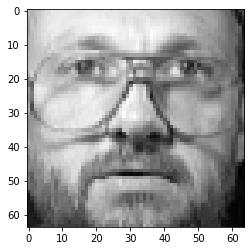

In [273]:
plt.imshow(row_data[0,:].reshape((64,64)))

In [274]:
from sklearn.decomposition import PCA
pca = PCA(n_components=400)
data_t = pca.fit_transform(row_data)

Ten sam obraz po redukcji PCA do 400 wymiarów i przywróceniu do pierwotnych rozmiarów. Jak widać pomimo zredukowania rozmiaru ponad dziesięciokrotnie (pierwotny rozmiar wynosił 64x64x=4096), po przywróceniu do pierwotnych wymiarów obraz jest nierozróżnialny gołym okiem od oryginału.

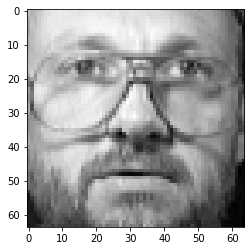

In [275]:
data_rt = pca.inverse_transform(data_t)
plt.imshow(data_rt[0,:].reshape((64,64)))


Sprawdźmy jak wygląda wykres zachowanej wariancji w zależność od docelowej liczby wymiarów. Przy liczbie 50 wymiarów, zachowana wariancja przestaje gwałtownie rosnąć.

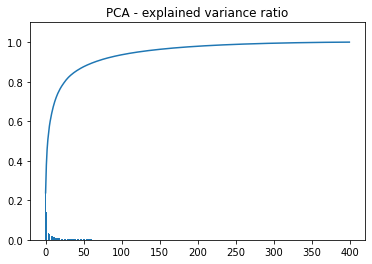

In [277]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0, np.cumsum(pca.explained_variance_ratio_).max() * 1.1)
plt.bar(range(400), pca.explained_variance_ratio_)
plt.title("PCA - explained variance ratio")
plt.show()

Sprawdźmy jak będzie zmieniać się stopień kompresjii (stosunek liczby wymiarów przed kompresją do liczby wymiarów po kompresji) oraz błąd RMSE pomiędzy odtworzonym obrazem i oryginałem.

In [278]:
from sklearn.metrics import mean_squared_error
results =[]
for c in range(10, 400, 10):
    pca = PCA(n_components=c)
    data_t = pca.fit_transform(row_data)
    size = pd.Series(data_t.shape)[1:].prod()
    compress_ratio = 4096/size
    data_rt = pca.inverse_transform(data_t)
    rmse = np.array([mean_squared_error(row_data[i], x, squared=False) for i, x in enumerate(data_rt)]).mean()
    #rmse = mean_squared_error(row_data, data_rt)
    results.append({'n_comp':c, 'compress_ratio':compress_ratio, 'rmse':rmse})
results_df = pd.DataFrame(results)

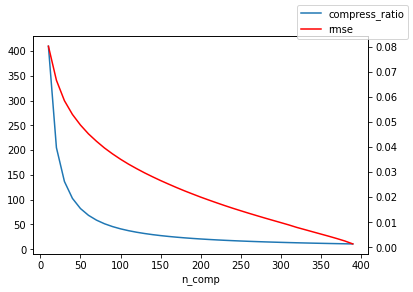

In [279]:
ax = results_df.plot(x="n_comp", y="compress_ratio", legend=False)
ax2 = ax.twinx()
results_df.plot(x="n_comp", y="rmse", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

Wartości błędów RMSE są bardzo małe dla każdej liczby wymiarów (wartości pixeli obrazów są od 0 do 1). Widać gwałtowny spadek stopnia kompresjii i błędu do mometnu gdy liczba wymiarów wynosi 50 (podobnie jak wyjaśniona wariancja pokazana wcześniej). Dla dalszych testów liczba 45 wymiarów wydaje się być dobra, ponieważ znajduje się jeszcze na "zboczu" spadającego stopnia kompresjii, a wartość RSME nadal jest bardzo mała. 

In [280]:
pca = PCA(n_components=45)
pca.fit(row_data)

PCA(n_components=45)

In [281]:
data_t = pca.transform(row_data)
data_rt = pca.inverse_transform(data_t)
rmses = []
for i in range(row_data.shape[0]):
    rmses.append(mean_squared_error(row_data[i,:], data_rt[i,:], squared=False))
rmses_unmodified = np.array(rmses)

## Modyfikacja obrazow
Sprawdźmy teraz czy i jak mocno zmodyfikowane wersje obrazów będą gorzej odtwarzane od tych z oryginalnego zbioru danych. Dla punktu odniesienia poniżej zostały odtworzone przykładowe obrazy bez ich wcześniejszej modyfikacji. 

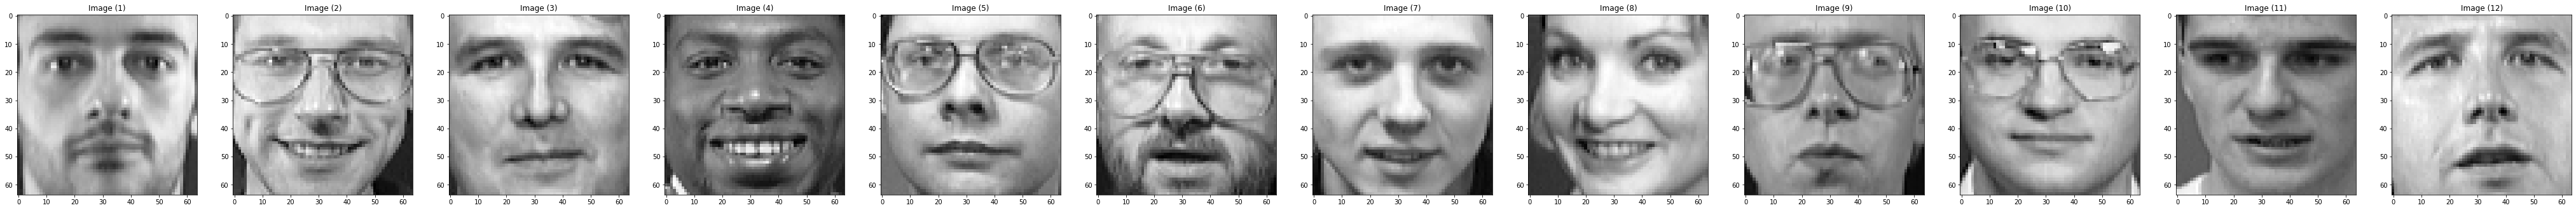

In [282]:
example_images = images[6:18,:,:]
show_images(example_images, cols=1)

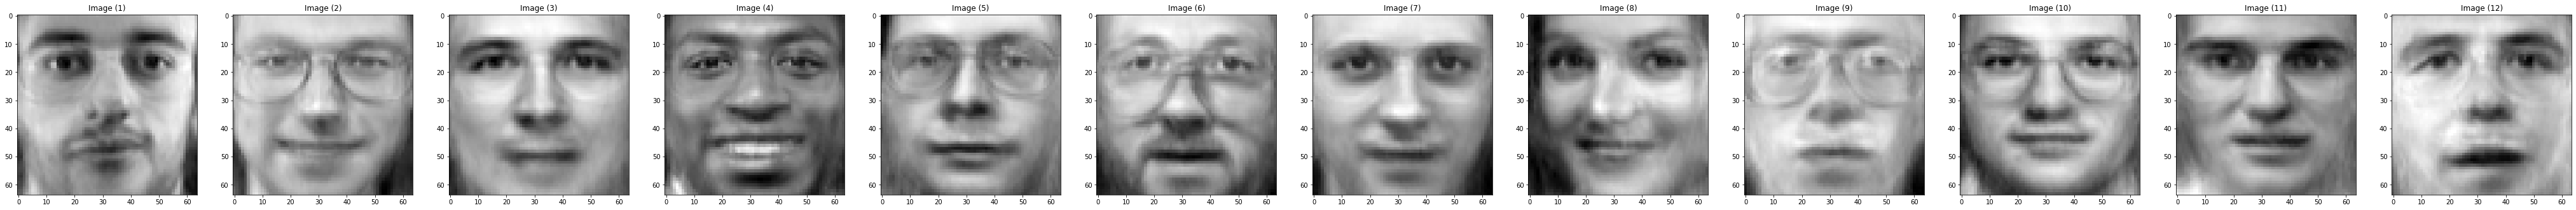

In [283]:
examples_t = pca.transform(example_images.reshape(12,-1))
examples_rt = pca.inverse_transform(examples_t)
show_images([x.reshape((64,64)) for x in examples_rt], cols=1)

In [284]:
example_images_rmses = rmses_unmodified[6:18]

### Obrót obrazu
Pierwszą modyfkicają obrazu będzie obrót obrazu o 90 stopni w prawo.

Jak widać PCA kompletnie nie potrafi odtworzyć takich obrazów, wszystkie odtworzone obrazy są bardzo rozmazane i są zorientowane poziomo.

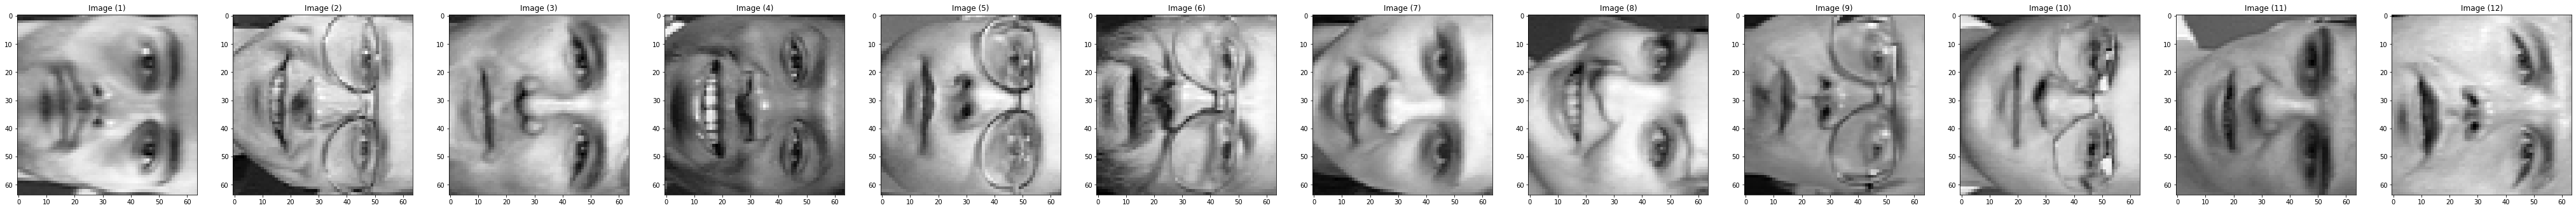

In [285]:
from skimage.transform import rotate
rotated_examples = np.array([rotate(x, -90) for x in example_images])
show_images(rotated_examples, cols=1)
rotated_examples = rotated_examples.reshape(12, -1)
rotated_examples_t = pca.transform(rotated_examples)
rotated_examples_rt = pca.inverse_transform(rotated_examples_t)
rotated_rmses = [mean_squared_error(rotated_examples[i,:], x, squared=False) for i, x in enumerate(rotated_examples_rt)]

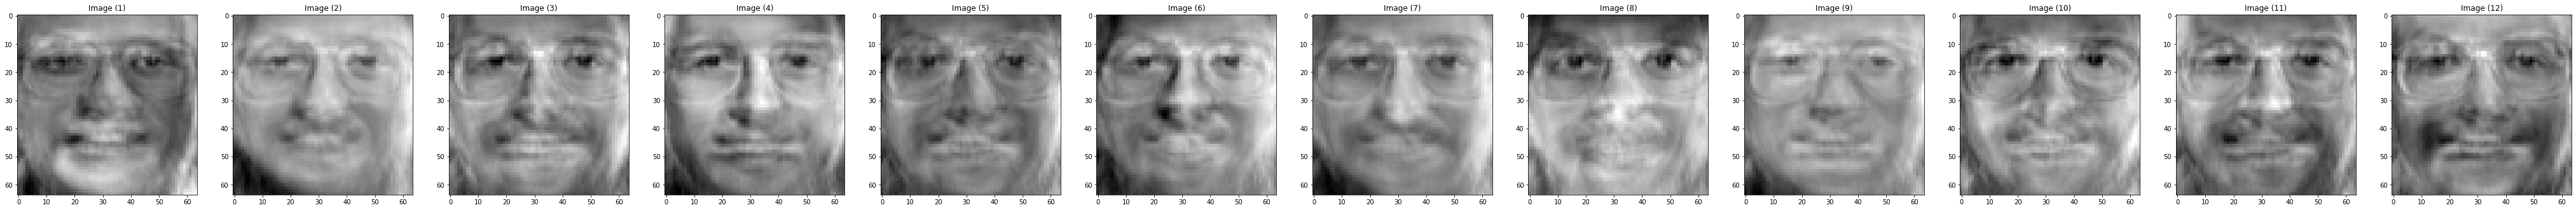

In [286]:
show_images([x.reshape((64,64)) for x in rotated_examples_rt], cols=1)

### Zmiana jasności
Kolejną modyfikacją jest przyciemnienie obrazu.

Po odtworzeniu widać że obrazy są ciemniejsze. Są jednak bardzo rozmazane i wygląda jakby każda postać na odtworzonych zdjęciach miała okulary.

In [287]:
from skimage import exposure

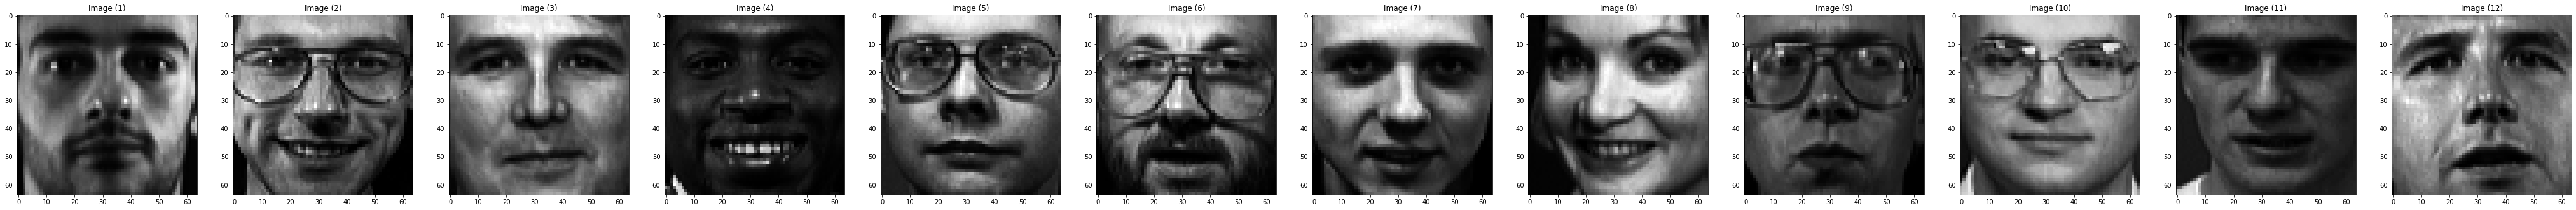

In [288]:
dimmed_examples = np.array([exposure.adjust_gamma(x, 3) for x in example_images])
show_images(dimmed_examples, cols=1)
dimmed_examples = dimmed_examples.reshape(12, -1)
dimmed_examples_t = pca.transform(dimmed_examples)
dimmed_examples_rt = pca.inverse_transform(dimmed_examples_t)
dimmed_rmses = [mean_squared_error(dimmed_examples[i,:], x, squared=False) for i, x in enumerate(rotated_examples_rt)]

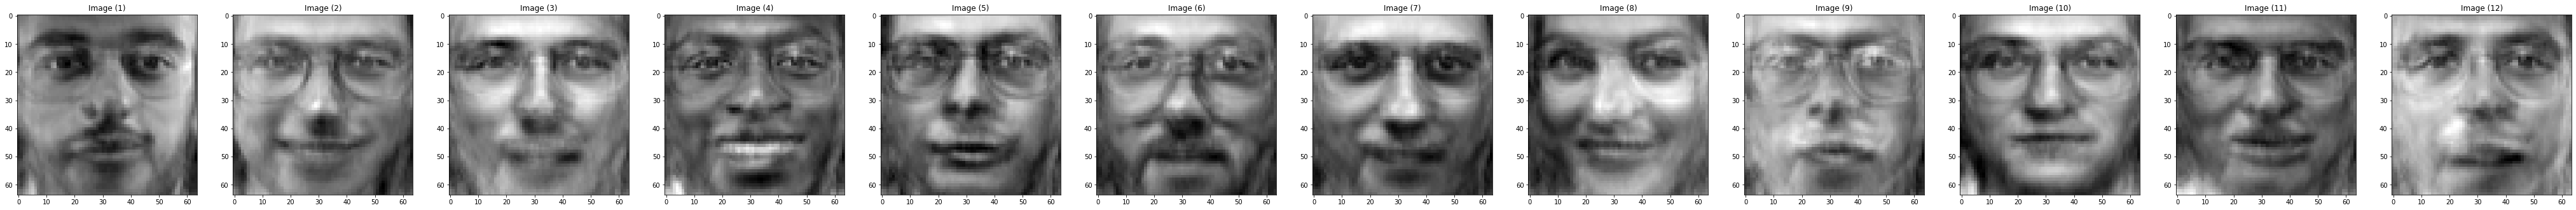

In [289]:
show_images([x.reshape((64,64)) for x in dimmed_examples_rt], cols=1)

### Przesunięcie
Można zauważyć że wszystkie zdjęcia są wykadrowane tak że nosy osób znajdują się zawsze na środku. Sprawdźmy jak PCA poradzi sobie ze zdjęciami gdzie twarze są przesunięte o 10 pixeli w prawo.

Tym razem również otrzymaliśmy bardzo słabe wyniki, wszystkie odwtorzone zdjęcia wyglądają niemal identycznie. Co ciekawe, twarze na odtworzonych zdjęciach są znów wyśrodkowane.

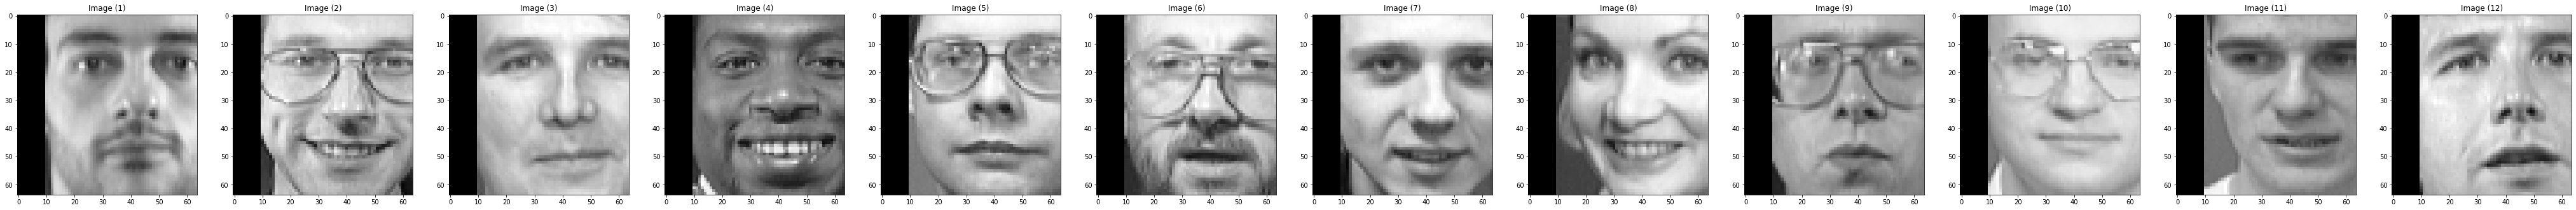

In [290]:
from scipy import ndimage
shifted_examples = np.array([ndimage.shift(x, (0,10), mode='constant') for x in example_images])
show_images(shifted_examples, cols=1)
shifted_examples = shifted_examples.reshape(12, -1)
shifted_examples_t = pca.transform(shifted_examples)
shifted_examples_rt = pca.inverse_transform(shifted_examples_t)
shifted_rmses = [mean_squared_error(shifted_examples[i,:], x, squared=False) for i, x in enumerate(rotated_examples_rt)]

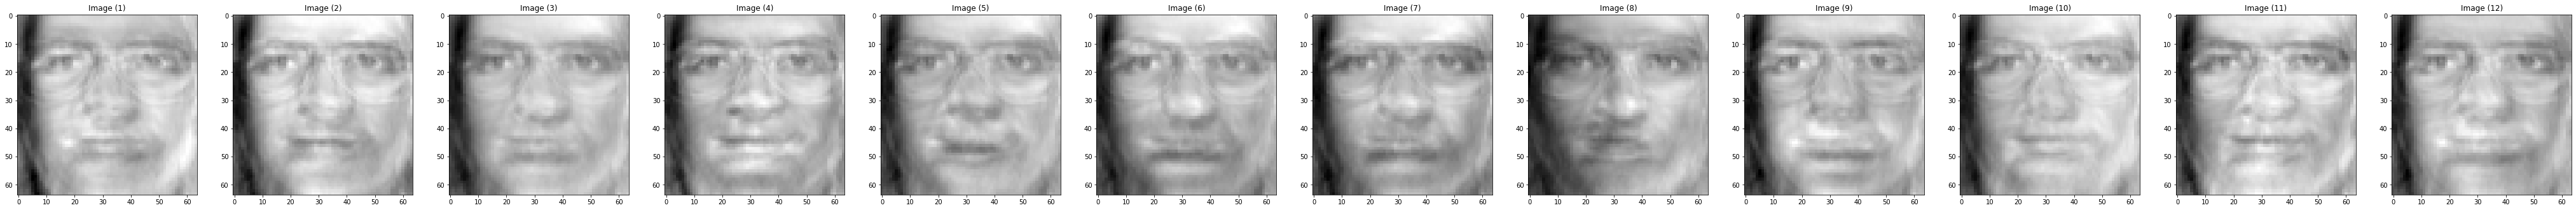

In [291]:
show_images([x.reshape((64,64)) for x in shifted_examples_rt], cols=1)

In [292]:
modifications_results = pd.DataFrame({'image_index':range(6,18), 'unchanged_rmse':example_images_rmses, 'rotated_rmse':rotated_rmses, 'dimmed_rmse':dimmed_rmses,
             'shifted_rmse':shifted_rmses})
modifications_results = modifications_results.melt(id_vars='image_index')

## Porównanie błędów RMSE modyfkiacji
Po wizualnej ocenie odtwarzania zmodyfikowanych zdjęć, sprawdźmy jak ich odtwarzanie wypadło w mierze RMSE. 

O dziwo, największym błędem RSME obarczona była modyfikacja polegająca na przyciemnieniu zdjęć, która wydawała się wypaść najlepiej.
Obrót obrazu, który przy odtwaraniu został kompletnie zignorowany, został obarczony najmniejszym błędem RMSE spośród modyfikacji.

PCA zostało dostosowane do zbioru zdjęć o podobnej jasności, stąd w ramach redukcji wymiarów mogło oprzeć komponenty które polagają na typowej jasności. W przypadku mocno ściemnionych zdjęć, mogła wystąpić trudność w odtworzeniu obniżonej jasności mając tylko komponenty oparte na typowej jasności. Dodatkowo RMSE jako miara jakości odtwarzania, większą wagę przykłada do jasności (wartość 'zapalenia' pixeli) niż do kształtów występujących na zdjęciu. Może to wyjaśniać dlaczego ściemnione zdjęcia uzyskały około 4x większy błąd niż zdjęcia obrócone, mimo tego że wizualnie wydaje się być na odwrót.

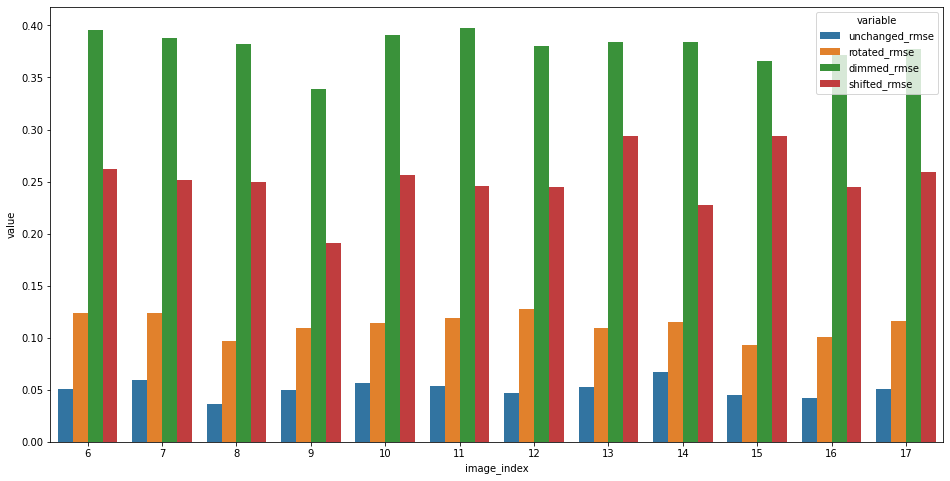

In [293]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.barplot(data=modifications_results, x='image_index', y='value', hue='variable')

## PCA jako wykrywanie anomalii
Jak wszelkie modyfkiacje zdjęć powodują znacznie większe błędy odtwarzania zdjęć. PCA może być więc sposobem na wykrywanie anomalii (podejrzane są te rekordy o wysokim błędzie odtwarzania), widać że największe błędy niezmodifykowanych zdjęć (0.07) nie sięgają najmniejszych błędów zmodyfikowanych zdjęć (0.1). Trzeba jednak być ostrożnym w doborze miary błędu odtwarzania. W naszym przypadku na zbiorze danych z twarzami, RMSE nie jest zbyt dobrym wyborem, ponieważ przyciemnione zdjęcia będą traktowane jako anomalia. Warto też dużą uwagę poświęcić na dane jakie posiadamy ponieważ użycie PCA w tym celu, polega w pewnym sensie na umyślnym overfittingu.

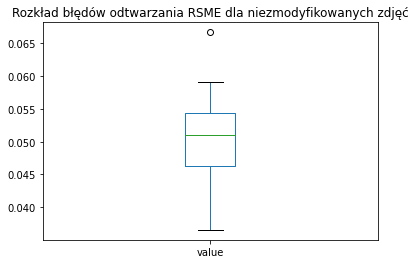

In [301]:
modifications_results[modifications_results['variable']=='unchanged_rmse']['value'].plot.box()
plt.title('Rozkład błędów odtwarzania RSME dla niezmodyfikowanych zdjęć')
plt.show()